# Automatic scoring of x-ray images

Import dependencies

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# PIL to open & manipulate images
from PIL import Image, ImageOps, ImageChops

# for messages in loops
from IPython.display import clear_output

# to save arrays
import h5py

# for folder-timestamp
from datetime import datetime

# for train/test split
from sklearn.model_selection import train_test_split
# for one-hot encoding
from sklearn.preprocessing import LabelBinarizer
# for class weights
from sklearn.utils import class_weight
# for model evaluation
from sklearn.metrics import confusion_matrix, classification_report
# for efficient loops
import itertools

# keras
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils import HDF5Matrix
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, \
    Dropout, Lambda, Activation, BatchNormalization
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import callbacks


Define image format & random seeds

In [2]:
# image format -> (rows, cols, channels)
K.set_image_data_format("channels_last")
# fix random seed for reproducibility
seed = 1
np.random.seed(seed)
tf.set_random_seed(seed)

In [3]:
with h5py.File('/data/joint_scoring/labels_train.h5', 'r') as hf:
    labels_train = hf['labels_train'][:]

# define class weights because of imbalance
weights = class_weight.compute_class_weight(class_weight='balanced', 
                                                 classes=np.unique(labels_train), 
                                                 y=labels_train)

print(max(weights)/min(weights))

weights = dict(enumerate(weights))
print(weights)

112.229885057
{0: 0.2468182438891165, 1: 0.61240428271328862, 2: 7.3563288563288562, 3: 15.980990274093722, 4: 27.700383141762451, 5: 12.358632478632479}


In [4]:
# model.fit does not work with class_weights for a HDF5 Matrix
# therefore, create sample weights

sample_weights = [ weights[x] for x in labels_train ]

sample_weights = np.array(sample_weights)

Import data as HDF5 Matrix

In [5]:
img_train = HDF5Matrix('/data/joint_scoring/img_train.h5', 'img_train')
img_test = HDF5Matrix('/data/joint_scoring/img_test.h5', 'img_test')

labels_train = HDF5Matrix('/data/joint_scoring/labels_train_onehot.h5', 'labels_train_onehot')
labels_test = HDF5Matrix('/data/joint_scoring/labels_test_onehot.h5', 'labels_test_onehot')

Preprocessing data in the same way Inception V3 was trained

In [42]:
num_classes = 6

## 2. Model

In [43]:
from tensorflow.python.keras.applications.inception_v3 import InceptionV3

In [53]:
model_1 = InceptionV3(include_top=False, weights='imagenet', input_shape=(150, 150, 3), pooling='avg')
model_1.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 150, 150, 3)   0                                            
____________________________________________________________________________________________________
conv2d_377 (Conv2D)              (None, 74, 74, 32)    864         input_5[0][0]                    
____________________________________________________________________________________________________
batch_normalization_385 (BatchNo (None, 74, 74, 32)    96          conv2d_377[0][0]                 
____________________________________________________________________________________________________
activation_385 (Activation)      (None, 74, 74, 32)    0           batch_normalization_385[0][0]    
___________________________________________________________________________________________

In [54]:
# adding custom output layer
x = model_1.output
x = Dense(units=1024, kernel_initializer="he_normal")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=512, kernel_initializer="he_normal")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(rate=0.5)(x)
predictions = Dense(units=num_classes, activation="softmax",
                    kernel_initializer="he_normal")(x)

In [55]:
from tensorflow.python.keras.models import Model
model = Model(inputs=model_1.input, outputs=predictions)

In [56]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 150, 150, 3)   0                                            
____________________________________________________________________________________________________
conv2d_377 (Conv2D)              (None, 74, 74, 32)    864         input_5[0][0]                    
____________________________________________________________________________________________________
batch_normalization_385 (BatchNo (None, 74, 74, 32)    96          conv2d_377[0][0]                 
____________________________________________________________________________________________________
activation_385 (Activation)      (None, 74, 74, 32)    0           batch_normalization_385[0][0]    
___________________________________________________________________________________________

In [57]:
from tensorflow.python.keras.optimizers import Adam
# learning rate 10 times smaller than usual
adam = Adam(lr=0.0001)

In [58]:
model.compile(optimizer=adam, loss="categorical_crossentropy", metrics=["accuracy"])

In [59]:
len(model.layers)

321

In [60]:
for layer in model.layers[0:-10]:
    layer.trainable = False

In [61]:
# create log directory
now = datetime.now
new_folder = '{}'.format(now().strftime('%Y%m%d_%H%M%S'))

In [62]:
print(new_folder)

20171127_204852


In [63]:
desc = "Transfer learning inception v3 classification model on original data with class weights"

with open("/data/joint_scoring/readme.txt", "a") as myfile:
    myfile.write("\n" + new_folder + "    " + desc)

In [64]:
# tensorboard callback
tb_callback = callbacks.TensorBoard(log_dir="/data/joint_scoring/tensorboard/" + new_folder,
                                    histogram_freq=0, write_graph=True,
                                    write_images=True)

In [19]:
print(len(img_train))
print(len(img_test))

72298
19611


In [20]:
# images need to be rgb (shape (150, 150, 3))
from IPython.display import clear_output
from PIL import Image

img_train_rgb = []
img_test_rgb = []

for i, img in enumerate(img_train):
    if i % 1000 == 0:
        clear_output()
        print("Converting train images to RGB, {0:.2f} % finished".format(i/72298*100))
    im = Image.fromarray((img.squeeze()).astype("int16"))
    im = im.convert("RGB")
    dat = np.array(im)
    img_train_rgb.append(dat)
    
for i, img in enumerate(img_test):
    if i % 1000 == 0:
        clear_output()
        print("Converting test images to RGB, {0:.2f} % finished".format(i/19611*100))
    im = Image.fromarray((img.squeeze()).astype("int16"))
    im = im.convert("RGB")
    dat = np.array(im)
    img_test_rgb.append(dat)

Converting test images to RGB, 96.88 % finished


In [21]:
img_train_rgb = np.array(img_train_rgb)
img_test_rgb = np.array(img_test_rgb)

In [22]:
from tensorflow.python.keras.applications.inception_v3 import preprocess_input

img_train_rgb = [preprocess_input(x) for x in img_train_rgb.astype("float32")]
img_test_rgb = [preprocess_input(x) for x in img_test_rgb.astype("float32")]

In [ ]:
img_train_rgb = np.array(img_train_rgb)
img_test_rgb = np.array(img_test_rgb)

In [65]:
# Fit the last few (newly added) layers of the model
model.fit(x=img_train_rgb, y=labels_train, batch_size=100, epochs=25, verbose=1,
          callbacks=[tb_callback], validation_data=(img_test_rgb, labels_test),
          shuffle="batch", sample_weight=sample_weights)

Train on 72298 samples, validate on 19611 samples
Epoch 1/25
72298/72298 [==============================] - 208s - loss: 1.7253 - acc: 0.3583 - val_loss: 1.1169 - val_acc: 0.5809
Epoch 2/25
72298/72298 [==============================] - 204s - loss: 1.3724 - acc: 0.5355 - val_loss: 0.9721 - val_acc: 0.6403
Epoch 3/25
72298/72298 [==============================] - 210s - loss: 1.1837 - acc: 0.5913 - val_loss: 1.1896 - val_acc: 0.5110
Epoch 4/25
72298/72298 [==============================] - 204s - loss: 1.0651 - acc: 0.6151 - val_loss: 0.9608 - val_acc: 0.6012
Epoch 5/25
72298/72298 [==============================] - 208s - loss: 0.9453 - acc: 0.6321 - val_loss: 1.0948 - val_acc: 0.5002
Epoch 6/25
72298/72298 [==============================] - 215s - loss: 0.8405 - acc: 0.6417 - val_loss: 0.8649 - val_acc: 0.6270
Epoch 7/25
72298/72298 [==============================] - 212s - loss: 0.7077 - acc: 0.6633 - val_loss: 0.8293 - val_acc: 0.6265
Epoch 8/25
72298/72298 [=======================

In [66]:
for layer in model.layers:
    layer.trainable = True

In [67]:
# Fit the whole model
model.fit(x=img_train_rgb, y=labels_train, batch_size=100, epochs=50, verbose=1,
          callbacks=[tb_callback], validation_data=(img_test_rgb, labels_test),
          shuffle="batch", sample_weight=sample_weights, initial_epoch=25)

Train on 72298 samples, validate on 19611 samples
Epoch 26/50
72298/72298 [==============================] - 198s - loss: 0.2232 - acc: 0.8370 - val_loss: 0.8910 - val_acc: 0.6364
Epoch 27/50
72298/72298 [==============================] - 198s - loss: 0.1976 - acc: 0.8470 - val_loss: 0.8400 - val_acc: 0.6929
Epoch 28/50
72298/72298 [==============================] - 200s - loss: 0.2546 - acc: 0.8379 - val_loss: 0.8183 - val_acc: 0.6943
Epoch 29/50
72298/72298 [==============================] - 198s - loss: 0.2295 - acc: 0.8407 - val_loss: 0.9068 - val_acc: 0.6150
Epoch 30/50
72298/72298 [==============================] - 201s - loss: 0.1571 - acc: 0.8734 - val_loss: 0.9189 - val_acc: 0.7160
Epoch 31/50
72298/72298 [==============================] - 198s - loss: 0.1291 - acc: 0.9027 - val_loss: 1.0024 - val_acc: 0.7146
Epoch 32/50
72298/72298 [==============================] - 198s - loss: 0.1366 - acc: 0.9030 - val_loss: 1.0007 - val_acc: 0.6457
Epoch 33/50
72298/72298 [===============

In [68]:
# Final evaluation of the model
scores = model.evaluate(img_test_rgb, labels_test, verbose=0)
print("Error: %.2f%%" % (100 - scores[1] * 100))

Error: 35.03%


In [69]:
# Save the model
model.save("/data/joint_scoring/models/" + new_folder + ".h5")

In [70]:
from sklearn.metrics import confusion_matrix, classification_report
p = model.predict(img_test_rgb)
pred = p.argmax(axis=-1)

print(classification_report(np.argmax(labels_test, axis=1), pred))
cnf_matrix = confusion_matrix(np.argmax(labels_test, axis=1), pred)
print(cnf_matrix)

             precision    recall  f1-score   support

          0       0.84      0.70      0.76     13286
          1       0.43      0.58      0.50      5369
          2       0.22      0.31      0.26       423
          3       0.20      0.26      0.23       177
          4       0.17      0.11      0.14        98
          5       0.43      0.66      0.52       258

avg / total       0.70      0.65      0.67     19611

[[9245 3898   64   15    2   62]
 [1777 3139  300   62   13   78]
 [  25  170  130   49   15   34]
 [   2   38   58   46    7   26]
 [   2   14   24   25   11   22]
 [   5   14   20   34   15  170]]


Confusion matrix, without normalization
[[9245 3898   64   15    2   62]
 [1777 3139  300   62   13   78]
 [  25  170  130   49   15   34]
 [   2   38   58   46    7   26]
 [   2   14   24   25   11   22]
 [   5   14   20   34   15  170]]
Normalized confusion matrix
[[  6.95845251e-01   2.93391540e-01   4.81710071e-03   1.12900798e-03
    1.50534397e-04   4.66656631e-03]
 [  3.30974111e-01   5.84652636e-01   5.58763271e-02   1.15477743e-02
    2.42130751e-03   1.45278450e-02]
 [  5.91016548e-02   4.01891253e-01   3.07328605e-01   1.15839243e-01
    3.54609929e-02   8.03782506e-02]
 [  1.12994350e-02   2.14689266e-01   3.27683616e-01   2.59887006e-01
    3.95480226e-02   1.46892655e-01]
 [  2.04081633e-02   1.42857143e-01   2.44897959e-01   2.55102041e-01
    1.12244898e-01   2.24489796e-01]
 [  1.93798450e-02   5.42635659e-02   7.75193798e-02   1.31782946e-01
    5.81395349e-02   6.58914729e-01]]


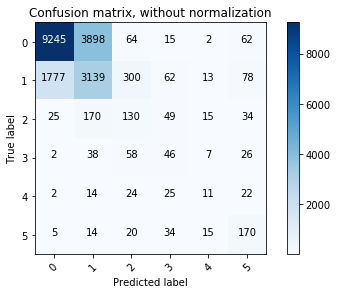

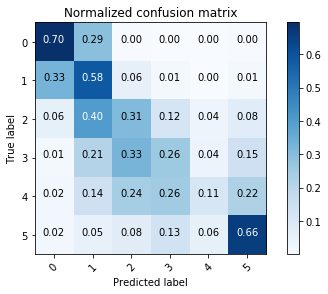

In [71]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(num_classes),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(num_classes), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [72]:
cm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
print("Mean accuracy per class")
print(np.mean(np.diag(cm)))

Mean accuracy per class
0.436478853939


In [73]:
upper = np.diag(cm, 1)
upper = np.append(upper, 0)
diagonal = np.diag(cm)
lower = np.diag(cm, -1)
lower = np.append(0, lower)

arr = np.vstack((upper, diagonal, lower))
print("Mean accuracy in the correct class or +- 1")
print(arr.sum(axis=0).mean())

Mean accuracy in the correct class or +- 1
0.786968101298


In [74]:
from nbconvert import HTMLExporter
import codecs
import nbformat
exporter = HTMLExporter()
output_notebook = nbformat.read('deepxray_classification_weights_transfer_learning.ipynb', as_version=4)
output, resources = exporter.from_notebook_node(output_notebook)
codecs.open("/data/joint_scoring/notebooks/" + new_folder + ".html", 'w', encoding='utf-8').write(output)